In [1]:
#imports

import numpy as np
import pandas as pd
import itertools
import time
import matplotlib.pyplot as plt
from heapq import nlargest
from scipy.sparse import coo_matrix #for sparse matrices
from scipy.sparse.linalg import eigs
import heapq
from sklearn.cluster import KMeans
from itertools import combinations




In [2]:
#helper functions

#convert a dataframe format to a matrix
def dataframe_to_matrix_fast(df, origin, destination, demand):
    nodes = np.unique(df[[origin, destination]].values)
    mapping = {n: i for i, n in enumerate(nodes)}
    N = len(nodes)

    row = df[origin].map(mapping).to_numpy()
    col = df[destination].map(mapping).to_numpy()
    values = df[demand].to_numpy()
    mat = np.zeros((N, N), dtype=float)
    np.add.at(mat, (row, col), values)

    return mat, mapping


#np.random to generate random data
def generate_uniform_synthetic_data(N, seed=42, low=1, high=1000):
    np.random.seed(seed)
    locs = [f"L{i}" for i in range(N)]
    demand = np.random.randint(low, high, size=(N, N)).astype(float)
    np.fill_diagonal(demand, 0.0)
    df = pd.DataFrame([(locs[i], locs[j], demand[i,j]) for i in range(N) for j in range(N) if i!=j],
                      columns=["Origin", "Destination", "Demand"])
    return df, demand, locs

#generate heavily biased synthetic data
def generate_biased_synthetic_data(N, seed=42, low=1, high=1000, bias_ratio=0.9, hub_fraction=0.1):

    np.random.seed(seed)
    locs = [f"L{i}" for i in range(N)]

    num_hubs = max(1, int(N * hub_fraction))
    hub_idx = np.random.choice(N, num_hubs, replace=False)
    hubs = [locs[i] for i in hub_idx]

    demand = np.random.randint(low, high, size=(N, N)).astype(float)
    np.fill_diagonal(demand, 0.0)

    bias_multiplier = (bias_ratio / hub_fraction) * 2
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            if (i in hub_idx) or (j in hub_idx):
                demand[i, j] = demand[i, j]*bias_multiplier

    # Normalization
    avg_val = np.mean(demand)
    scale = (high + low) / 2 / avg_val
    demand = demand*scale

    df = pd.DataFrame([(locs[i], locs[j], demand[i, j])
                       for i in range(N) for j in range(N) if i != j],
                      columns=["Origin", "Destination", "Demand"])

    return df, demand, locs

#givena list of chosen vertiports, compute how much demand is captured by it.
def captured_demand(demand_matrix, chosen):
    if len(chosen) < 2:
        return 0
    return demand_matrix[np.ix_(chosen, chosen)].sum()

In [4]:
#algorithms

#greedy algorithm - using numpy to optimize but still have to loop over M
def greedy_station_selection(demand_matrix, M):
    N = demand_matrix.shape[0]
    chosen = []
    remaining = list(range(N))
    #conn = demand_matrix.sum(0) + demand_matrix.sum(1)
    conn = np.array(demand_matrix.sum(axis=0)).ravel() + np.array(demand_matrix.sum(axis=1)).ravel()
    first = int(np.argmax(conn))
    chosen.append(first)
    remaining.remove(first)

    while len(chosen) < M:
        best = None
        best_gain = -1
        for loc in remaining:
            gain = demand_matrix[loc, chosen].sum() + demand_matrix[chosen, loc].sum()
            if gain > best_gain:
                best_gain = gain
                best = loc
        best = int(best)
        chosen.append(best)
        remaining.remove(best)

    total = captured_demand(demand_matrix, chosen)
    return chosen, total

def greedy_station_selection_topM(demand_matrix, M):
    conn = np.array(demand_matrix.sum(axis=0)).ravel() + np.array(demand_matrix.sum(axis=1)).ravel()

    top_indices = np.argsort(conn)[::-1][:M]
    chosen = top_indices.tolist()

    total = captured_demand(demand_matrix, chosen)

    return chosen, total

def greedy_station_selection_vectorized(demand_matrix, M):
    N = demand_matrix.shape[0]
    chosen = []

    conn = demand_matrix.sum(axis=0) + demand_matrix.sum(axis=1)
    first = np.argmax(conn)
    chosen.append(first)

    remaining_mask = np.ones(N, dtype=bool)
    remaining_mask[first] = False

    captured = np.zeros((N,), dtype=float)

    while len(chosen) < M:
        current = np.array(chosen)

        remaining = np.where(remaining_mask)[0]
        gains = demand_matrix[remaining][:, current].sum(axis=1) + demand_matrix[current][:, remaining].sum(axis=0)

        best_idx = np.argmax(gains)
        best_node = remaining[best_idx]

        chosen.append(best_node)
        remaining_mask[best_node] = False

    total = demand_matrix[np.ix_(chosen, chosen)].sum()
    return chosen, total

def evaluate_subset(chosen_subset, demand_matrix):
        return demand_matrix[np.ix_(chosen_subset, chosen_subset)].sum()

def lookahead(chosen, remaining_mask, steps_left, current_depth, demand_matrix, best):
        if steps_left == 0:
            return evaluate_subset(chosen, demand_matrix), chosen

        remaining_indices = np.where(remaining_mask)[0]
        current = np.array(chosen)
        gains = demand_matrix[remaining_indices][:, current].sum(axis=1) + \
                demand_matrix[current][:, remaining_indices].sum(axis=0)

        if current_depth == 0:
            chosen_ext = chosen.copy()
            rem_mask = remaining_mask.copy()
            while len(chosen_ext) < M:
                rem_idx = np.where(rem_mask)[0]
                curr = np.array(chosen_ext)
                g = demand_matrix[rem_idx][:, curr].sum(axis=1) + \
                    demand_matrix[curr][:, rem_idx].sum(axis=0)
                best_node = rem_idx[np.argmax(g)]
                chosen_ext.append(best_node)
                rem_mask[best_node] = False
            return evaluate_subset(chosen_ext, demand_matrix), chosen_ext

        k = min(best, len(gains))
        top_indices = np.argpartition(-gains, k-1)[:k]

        best_total = -np.inf
        best_path = None

        for idx in top_indices:
            node = remaining_indices[idx]
            new_chosen = chosen + [node]
            new_mask = remaining_mask.copy()
            new_mask[node] = False
            total, path = lookahead(new_chosen, new_mask, steps_left - 1, current_depth - 1)
            if total > best_total:
                best_total, best_path = total, path

        return best_total, best_path


def greedy_station_selection_lookahead(demand_matrix, M, best=2, depth=1, last=0):
    N = demand_matrix.shape[0]
    chosen = []

    conn = demand_matrix.sum(axis=0) + demand_matrix.sum(axis=1)
    first = int(np.argmax(conn))
    chosen.append(first)

    remaining_mask = np.ones(N, dtype=bool)
    remaining_mask[first] = False

    while len(chosen) < M:
        steps_left = M - len(chosen)
        remaining_indices = np.where(remaining_mask)[0]
        current = np.array(chosen)
        gains = demand_matrix[remaining_indices][:, current].sum(axis=1) + \
                demand_matrix[current][:, remaining_indices].sum(axis=0)

        apply_lookahead = (steps_left <= last and depth > 1)

        if apply_lookahead:
            x, best_path = lookahead(chosen, remaining_mask, steps_left, depth, demand_matrix, best)
            chosen = best_path
            break
        else:
            best = np.argmax(gains)
            best_node = remaining_indices[best]
            chosen.append(best_node)
            remaining_mask[best_node] = False

    total = evaluate_subset(chosen, demand_matrix)
    return chosen, total


#just literal brute force, max_time of 60 seconds to abort run
def brute_force_station_selection(demand_matrix, M, max_time=60):
    N = demand_matrix.shape[0]
    start = time.time()
    best = None
    best_val = -1
    for combo in itertools.combinations(range(N), M):
        if (time.time() - start) > max_time:
            print(f"[brute force] TIME LIMIT hit at {round(time.time()-start,2)}s!")
            return (list(best) if best else [], best_val)
        val = captured_demand(demand_matrix, combo)
        if val > best_val:
            best_val = val
            best = combo
    return list(best), best_val


#using branch pruning trick
class BranchAndBoundSolver:
    def __init__(self, demand_matrix, M, time_limit=60, greedy_init=None):
        self.D = demand_matrix
        self.N = demand_matrix.shape[0]
        self.M = M
        self.time_limit = time_limit
        self.best_val = -1
        self.best_set = []
        self.start_time = None
        self.conn = self.D.sum(0) + self.D.sum(1)
        self.visited = 0
        self.pruned = 0

        # If a greedy warm start is provided, use it
        if greedy_init is not None:
            greedy_sel, greedy_val = greedy_init
            self.best_val = greedy_val
            self.best_set = greedy_sel[:]
            print(f"[warm start] Using Greedy init with value={round(greedy_val,2)}")

    def time_up(self):
        return (time.time() - self.start_time) > self.time_limit

    def upper_bound(self, chosen, remaining):
        if len(chosen) <= 1:
            cur = 0
        else:
            cur = captured_demand(self.D, chosen)
        need = self.M - len(chosen)
        if need <= 0:
            return cur
        top = nlargest(need, self.conn[remaining])
        return cur + sum(top)

    def solve(self):
        self.start_time = time.time()
        all_nodes = list(range(self.N))
        all_nodes.sort(key=lambda x: -self.conn[x])
        self.dfs([], all_nodes)
        elapsed = time.time() - self.start_time
        return {"best_set": self.best_set, "best_val": self.best_val,
                "visited": self.visited, "pruned": self.pruned, "time": elapsed}

    def dfs(self, chosen, remaining):
        if self.time_up():
            return
        self.visited += 1
        if len(chosen) == self.M:
            val = captured_demand(self.D, chosen)
            if val > self.best_val:
                self.best_val = val
                self.best_set = chosen[:]
            return
        if not remaining:
            return
        ub = self.upper_bound(chosen, remaining)
        if ub <= self.best_val:
            self.pruned += 1
            return
        for i, node in enumerate(remaining):
            if self.time_up():
                return
            new_chosen = chosen + [node]
            new_remaining = remaining[i+1:]
            if len(new_chosen) + len(new_remaining) < self.M:
                continue
            self.dfs(new_chosen, new_remaining)

In [30]:
#data ingestion
df = pd.read_csv("TLC_demand_by_tracts.csv")
start = time.time()
matrix, mapping = dataframe_to_matrix_fast(df, "origin_tract", "destination_tract", "demand")
#matrix, _, _ = dataframe_to_sparse_matrix(df, "origin_tract", "destination_tract", "demand")
print(f"Step 1: Created matrix in {time.time() - start:.2f} seconds")
print(f"Matrix shape: {matrix.shape}")


#x, big_demand, big_locs = generate_uniform_synthetic_data(2323, seed=1234)
#matrix = big_demand

start = time.time()
chosen2, total2 = greedy_station_selection_topM(matrix, 100)
print(f"Step 2: greedy_station_selection_topM finished in {time.time() - start:.2f} seconds")
print(f"Chosen: {len(chosen2)} stations, Total demand: {total2}")

start = time.time()
chosen1, total1 = greedy_station_selection(matrix, 100)
print(f"Step 3: greedy_station_selection finished in {time.time() - start:.2f} seconds")
print(f"Chosen: {len(chosen1)} stations, Total demand: {total1}")

start = time.time()
chosen1, total1 = greedy_station_selection_vectorized(matrix, 100)
print(f"Step 4: greedy_station_selection_vectorized finished in {time.time() - start:.2f} seconds")
print(f"Chosen: {len(chosen1)} stations, Total demand: {total1}")

#start = time.time()
#solver = BranchAndBoundSolver(matrix, 100, time_limit=60, greedy_init=(chosen1, total1))
#out = solver.solve()
#print(f"Step 5: B&B finished in {time.time() - start:.2f} seconds")
#print(out['best_val'])

reverse_map = {i: n for n, i in mapping.items()}
chosen_original = [reverse_map[i] for i in chosen1]


print(chosen_original)

#start = time.time()
#chosen1, total1 = exact_lookahead_incremental(matrix, 100, 100, 99)
#print(f"Step 4: exact_lookahead_greedy_fixed finished in {time.time() - start:.2f} seconds")
#print(f"Chosen: {len(chosen1)} stations, Total demand: {total1}")


#start = time.time()
#chosen1, total1 = greedy_station_selection_lookahead(matrix, 100, 2, 5, 99)
#print(f"Step 4: greedy_station_selection_lookahead finished in {time.time() - start:.2f} seconds")
#print(f"Chosen: {len(chosen1)} stations, Total demand: {total1}")



Step 1: Created matrix in 1.29 seconds
Matrix shape: (2323, 2323)
Step 2: greedy_station_selection_topM finished in 0.01 seconds
Chosen: 100 stations, Total demand: 16052614.80627952
Step 3: greedy_station_selection finished in 4.00 seconds
Chosen: 100 stations, Total demand: 16127487.837062437
Step 4: greedy_station_selection_vectorized finished in 1.59 seconds
Chosen: 100 stations, Total demand: 16127487.837062437
[np.int64(4071600), np.int64(4033100), np.int64(1011900), np.int64(1012500), np.int64(1013100), np.int64(1013700), np.int64(1001300), np.int64(1009200), np.int64(1010000), np.int64(1009600), np.int64(1031703), np.int64(1010400), np.int64(1000700), np.int64(1010200), np.int64(1000900), np.int64(1010100), np.int64(1031704), np.int64(1009500), np.int64(1007400), np.int64(1014300), np.int64(1007600), np.int64(1003300), np.int64(1001502), np.int64(1008400), np.int64(1010900), np.int64(1011300), np.int64(1003900), np.int64(1009400), np.int64(1007800), np.int64(1001501), np.int64(

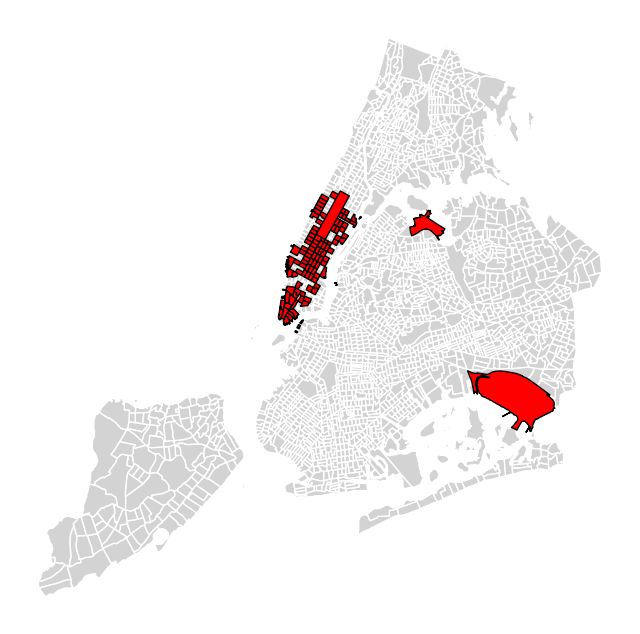

In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt

shapefile_path = "nyct2020.shp"
gdf = gpd.read_file(shapefile_path)

selected_tracts = [4071600, 4033100, 1011900, 1012500, 1013100, 1013700, 1001300, 1009200, 1010000, 1009600,1031703, 1010400, 1000700, 1010200, 1000900, 1010100, 1031704, 1009500, 1007400, 1014300,1007600, 1003300, 1001502, 1008400, 1010900, 1011300, 1003900, 1009400, 1007800, 1001501,1007200, 1013800, 1008200, 1008000, 1002100, 1003700, 1001800, 1013900, 1004900, 1015200,1004100, 1011500, 1013300, 1003100, 1012700, 1014200, 1014000, 1001600, 1014402, 1009903,1003200, 1011600, 1011201, 1011202, 1003800, 1004700, 1016300, 1009901, 1011203, 1018300,1004300, 1013400, 1017500, 1012400, 1017900, 1008800, 1011800, 1006500, 1011000, 1018900,1009800, 1005800, 1005600, 1015700, 1006400, 1014602, 1004800, 1014500, 1006800, 1006200,1014900, 1005200, 1015801, 1005400, 1016001, 1015002, 1014802, 1005000, 1003400, 1017100,1009300, 1009100, 1016500, 1007900, 1016700, 1008100, 1012800, 1013000, 1007700, 1011100
]

gdf_selected = gdf[gdf['BoroCT2020'].astype(int).isin(selected_tracts)]

fig, ax = plt.subplots(figsize=(8, 8))

gdf.plot(ax=ax, color='lightgray', edgecolor='white')
gdf_selected.plot(ax=ax, color='red', edgecolor='black')

ax.set_axis_off()
plt.show()

In [ ]:
#test and compare

# Generate big dataset (N=3000) ONCE
bigN = 1000
print(f"Generating synthetic data for N={bigN} ...")

#different data generation processes
#x, big_demand, big_locs = generate_uniform_synthetic_data(bigN, seed=1234)
#x, big_demand, big_locs = generate_biased_synthetic_data(bigN, seed=1234)
x, big_demand, big_locs = generate_biased_synthetic_data(bigN, seed=1234,  bias_ratio=0.9, hub_fraction=0.01)

pairs = [
    #(10, 3), (10, 5),
    #(50, 3), (50, 5), (50, 10),
    #(100, 3), (100, 5),  (100, 10), (100, 50),
    #(500, 3), (500, 5), (500, 10),
     (500, 50)#, (500, 100),
    #(1000, 3), (1000, 5), (1000, 10), (1000, 50), (1000, 100), (1000, 300)
    #(3000, 3), (3000, 5), (3000, 10), (3000, 25), (3000, 50), (3000, 100), (3000, 300)
]

results = []

for N, M in pairs:
    print(f"\n=== TEST N={N}, M={M} ===")
    demand = big_demand[:N,:N]
    locs = big_locs[:N]

    #Greedy
    t0 = time.time()
    greedy_sel, greedy_val = greedy_station_selection(demand, M)
    gtime = time.time() - t0
    print(f"[GREEDY] time={round(gtime,3)}s, captured={round(greedy_val,2)}")

    #Brute Force
    t0 = time.time()
    bf_sel, bf_val = brute_force_station_selection(demand, M, max_time=60)
    bftime = time.time() - t0
    bf_forced = bftime > 59.5
    print(f"[BRUTE]  time={round(bftime,3)}s, captured={round(bf_val,2)}{' (FORCED STOP)' if bf_forced else ''}")

    #Branch and Bound (use greedy init)
    solver = BranchAndBoundSolver(demand, M, time_limit=60, greedy_init=(greedy_sel, greedy_val))
    out = solver.solve()
    bbtime = out["time"]
    bb_forced = bbtime > 59.5
    print(f"[B&B]    time={round(bbtime,3)}s, captured={round(out['best_val'],2)}, visited={out['visited']}, pruned={out['pruned']}{' (FORCED STOP)' if bb_forced else ''}")

    results.append({
        "N": N,
        "M": M,
        "Greedy_time": round(gtime,3),
        "Greedy_val": round(greedy_val,2),
        "Brute_time": round(bftime,3),
        "Brute_val": round(bf_val,2),
        "Brute_forced": bf_forced,
        "BB_time": round(bbtime,3),
        "BB_val": round(out["best_val"],2),
        "BB_forced": bb_forced
    })


Generating synthetic data for N=1000 ...

=== TEST N=500, M=50 ===
[GREEDY] time=0.363s, captured=10328600.71
[brute force] TIME LIMIT hit at 60.0s!
[BRUTE]  time=60.0s, captured=4231952.82 (FORCED STOP)
[warm start] Using Greedy init with value=10328600.71
[B&B]    time=60.0s, captured=10360069.5, visited=1444689, pruned=4001 (FORCED STOP)


In [ ]:
import pandas as pd
import numpy as np
import time

# --- Setup: Create DataFrame with 1 million rows ---
N_ROWS = 1000000
df = pd.DataFrame({
    'col_A': np.random.rand(N_ROWS),
    'col_B': np.random.rand(N_ROWS),
    'col_C': 0 # Initialize the result column
})

start_time = time.time()
df['col_C_vectorized'] = (df['col_A'] * 2.5) * np.power(df['col_B'],df['col_A'])
vectorized_time = time.time() - start_time

def operation_apply(row):
    return (row['col_A'] * 2.5) * np.power(row['col_B'],row['col_A'])

start_time = time.time()
df['col_C_apply'] = df.apply(operation_apply, axis=1)
apply_time = time.time() - start_time

results = []
start_time = time.time()
for index, row in df.iterrows():
    results.append((row['col_A'] * 2.5) * np.power(row['col_B'],row['col_A']))
df['col_C_iterrow'] = results
iterrow_time = time.time() - start_time

print(f"Time for {N_ROWS:,} rows and 3 columns:")
print("-" * 50)
print(f"1. Vectorized Operation: {vectorized_time:.4f} seconds")
print(f"2. Using .apply(axis=1):   {apply_time:.4f} seconds")
print(f"3. Row-by-Row Iteration (.iterrows()): {iterrow_time:.4f} seconds")

all_equal = (df['col_C_vectorized'] - df['col_C_apply']).abs().max() < 1e-9 and \
            (df['col_C_vectorized'] - df['col_C_iterrow']).abs().max() < 1e-9
print(f"Results are numerically equal: {all_equal}")

Time for 1,000,000 rows and 3 columns:
--------------------------------------------------
1. Vectorized Operation: 0.0372 seconds
2. Using .apply(axis=1):   12.2770 seconds
3. Row-by-Row Iteration (.iterrows()): 38.9896 seconds
Results are numerically equal: True
